In [1]:
# Import libraries:
import xarray
import numpy as np
import pandas as pd
import os
from six.moves import urllib
from glob import glob
import matplotlib.pyplot as plt
import matplotlib  as mpl 
import pickle
import pyart
from datetime import datetime
import math
from pandas.core.common import flatten
%matplotlib inline
# %matplotlib widget
import tobac
from tobac.merge_split import merge_split_cells

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Import tobac itself:
import tobac
from tobac.merge_split import merge_split_cells
#Disable a couple of warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [3]:
def qc_reflectivity2(dataset,rhv, ref = None):
    for i in range(len(dataset['time'])):
        refl = np.array(dataset['reflectivity'][i, :, :, :])
        refl[np.array(dataset['cross_correlation_ratio'][i, :, :, :]) < rhv] = -999 #0
        #refl[np.array(dataset['correlation_coefficient'][i, :, :, :]) < rhv] = -999 #0
        if ref:
            refl[refl < ref] = np.nan #-999 #0
        dataset['reflectivity'][i, :, :, :] = refl
        max_refl = dataset['reflectivity'].max(axis=1,skipna=True)
        #p = np.where(max_refl)
        #dataset = dataset.assign(max_reflectivity=lambda dataset:max_refl)
    return max_refl

In [50]:
path = "/Users/kelcy/DATA/20220604/"
data = xarray.open_mfdataset(path+'*grid.nc', engine = 'netcdf4')
data['time'].encoding['units']="seconds since 2000-01-01 00:00:00"
rho = 0.90
ref =  10
maxrefl = qc_reflectivity2(data,rho,ref = ref)


In [44]:
#Set up directory to save output and plots:
savedir='tobac_Save_20220604'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plot_dir="tobac_Plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

#Feature detection:
#Feature detection is perfomed based on surface precipitation field and a range of thresholds

In [45]:
# Dictionary containing keyword options (could also be directly given to the function)
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']= 1.0 #is the default
parameters_features['threshold']= 15
#parameters_features['min_num']=0
#parameters_features['min_distance']=5 #0 #15
#parameters_features['n_erosion_threshold']=0
#parameters_features['n_min_threshold']=0

In [46]:
# #Dt, DXY
datetimes = data['time']
timedeltas = [(datetimes[i-1]-datetimes[i]).astype('timedelta64[m]') for i in range(1, len(datetimes))]
print(len(timedeltas))
average_timedelta = sum(timedeltas) / len(timedeltas)
dt = np.abs(np.array(average_timedelta)).astype('timedelta64[m]').astype(int)


deltax = [data['x'][i-1]-data['x'][i] for i in range(1, len(data['x']))]
dxy = np.abs(np.mean(deltax).astype(int))/1000


print(dxy,dt)
# dxy = 0.5
# dt = 5
# # del data

141
0.5 7


In [47]:
maxrefl_iris=maxrefl.to_iris()
# Feature detection based on based on surface precipitation field and a range of thresholds
print('starting feature detection based on multiple thresholds')
Features_iris=tobac.feature_detection_multithreshold(maxrefl_iris,dxy,**parameters_features)
Features=Features_iris.to_xarray()
print('feature detection done')
Features.to_netcdf(os.path.join(savedir,'Features.nc'))
print('features saved')

starting feature detection based on multiple thresholds
feature detection done
features saved


In [10]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']= 15  # mm/h mixing ratio
#parameters_segmentation['ISO_dilate']=10 #this is the size 
#parameters_segmentation['features']
#parameters_segmentation['field']
#parameters_segmentation['dxy']
#parameters_segmentation['target']
#parameters_segmentation['level']
#parameters_segmentation['method']
#parameters_segmentation['max_distance']
#Maximum distance from a marker allowed to be classified as
        #belonging to that cell. Default is None.
#parameters_segmentation['vertical_coord']

In [14]:
Features_df=Features.to_dataframe()

# Perform Segmentation and save resulting mask to NetCDF file:
print('Starting segmentation based on reflectivity')
Mask_iris,Features_Precip =tobac.segmentation.segmentation(Features_df,maxrefl_iris,dxy,**parameters_segmentation)
#Mask,Features_Precip=tobac.themes.tobac_v1.segmentation(Features,maxrefl,dxy,**parameters_segmentation)
Features_Precip=Features_Precip.to_xarray()
Mask=xarray.DataArray.from_iris(Mask_iris)
Mask = Mask.to_dataset()


#Mask,Features_Precip=segmentation(Features,maxrefl,dxy,**parameters_segmentation)
print('segmentation based on reflectivity performed, start saving results to files')
Mask.to_netcdf(os.path.join(savedir,'Mask_Segmentation_refl.nc'))                
Features_Precip.to_netcdf(os.path.join(savedir,'Features_Precip.nc'))
print('segmentation reflectivity performed and saved')

Starting segmentation based on reflectivity
segmentation based on reflectivity performed, start saving results to files
segmentation reflectivity performed and saved


In [15]:
areas = np.zeros([(len(Features['index'])+1)])
maxfeature_refl = np.zeros([(len(Features['index'])+1)])
#Mask = Mask.to_dataset()
frame_features = Features.groupby('frame')

for frame_i, features_i in frame_features: 
#     print(frame_i)
#     print(features_i)
    mask_i = Mask['segmentation_mask'][frame_i,:,:].values
    subrefl = maxrefl[frame_i,:,:].values
    for i in np.unique(mask_i):
        feature_area_i = np.where(mask_i == i)
        areas[i] = len(feature_area_i[0])
        maxfeature_refl[i] = np.nanmax(subrefl[feature_area_i])


var = Features['feature'].copy(data = areas[1:])
var = var.rename("areas")
var_max = Features['feature'].copy(data = maxfeature_refl[1:])
var_max = var_max.rename("max_reflectivity")
Features_Precip = xarray.merge([Features_Precip,var], compat = 'override')
Features = xarray.merge([Features,var], compat = 'override')
Features = xarray.merge([Features,var_max], compat = 'override')
Features_Precip.to_netcdf(os.path.join(savedir, 'Features_Precip.nc'))
Features.to_netcdf(os.path.join(savedir,'Features.nc'))
Mask = Mask.to_array()
Features_df=Features.to_dataframe()
print('features saved')

features saved


In [22]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['stubs'] = 5#3
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0#2 #was 1 - the number of frames to extrapolate to
parameters_linking['order']=2 #Order of polynomial for extrapolating
parameters_linking['subnetwork_size']=100 #50 #100
parameters_linking['memory']= 2#3#4
#parameters_linking['time_cell_min']=1
parameters_linking['v_max']=0.9#1.0 #.0 #1.2 #2.0#.5
parameters_linking['d_min']= None #5 

In [25]:
# Perform trajectory linking using trackpy and save the resulting DataFrame:

#Track=tobac.themes.tobac_v1.linking_trackpy(Features,Mask,dt=dt,dxy=dxy,**parameters_linking)
Features_df=Features.to_dataframe()
Track=tobac.linking_trackpy(Features_df,Mask_iris,dt=dt,dxy=dxy,**parameters_linking)
print(type(Track))
Track = Track.to_xarray()
Track.to_netcdf(os.path.join(savedir,'Track.nc'))

Frame 141: 9 trajectories present.
<class 'pandas.core.frame.DataFrame'>


In [32]:
Track = xarray.open_dataset(savedir+"/Track.nc")
Track = Track.to_dataframe()
Features = xarray.open_dataset(savedir+"/Features.nc")
refl_mask = xarray.open_dataset(savedir+"/Mask_Segmentation_refl.nc")
refl_features = xarray.open_dataset(savedir+"/Features_Precip.nc")
# both_ds = xarray.open_dataset(savedir+'/Track_features_merges.nc')

In [33]:
# d, track_id = merge_split(Track,distance = 20000.)
import time
tic = time.perf_counter()


d = merge_split_cells(Track,500., distance=20000.0)
toc = time.perf_counter()
print(toc - tic)
#d = d.to_dataframe()
Track = xarray.open_dataset(savedir+"/Track.nc")
ds = tobac.utils.standardize_track_dataset(Track, refl_mask)#, data['ProjectionCoordinateSystem'])
# # # both_ds = xr.combine_by_coords((ds,d), compat='override')
both_ds = xarray.merge([ds, d],compat ='override')
both_ds = tobac.utils.compress_all(both_ds)
both_ds.to_netcdf(os.path.join(savedir,'Track_features_merges.nc'))

1.0825152500001423


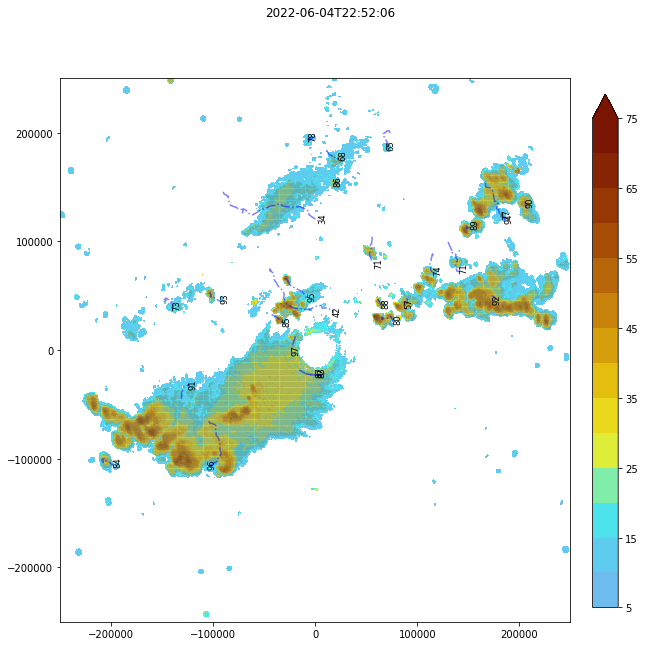

In [36]:
#
frame = 56
isolated_min = 0.5
show_tracks = True
ref_levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
# for j in range(len(maxrefl.time)):
#     print(j)
#     if j <= 33:89
#         continue
#     if j>= 41:
#         continue
#     frame = j
fig, ax = plt.subplots(figsize=(10,10))

refl = maxrefl[frame,:,:] #data['max_reflectivity'][id,:,:]
fig.suptitle(str(data['time'][frame].data)[:-10])# + 'rhohv = '+str(rho) + ', ref > ' + str(ref))
y_mesh,x_mesh = np.meshgrid(data['x'],data['y'])
    
refplt = ax.contourf(y_mesh,x_mesh, refl, extend = 'max',levels = ref_levels,cmap='pyart_LangRainbow12',origin = 'lower', vmin=-24, vmax=72)#,extent = [0,-10000,-20000,-10000])
fig.colorbar(refplt,fraction=0.046, pad=0.04)
i = np.where(both_ds['segmentation_mask'][frame,:,:] > 0)
y, x = y_mesh[i[0],i[1]],x_mesh[i[0],i[1]]
imcell2 = ax.scatter(y,x,s = 0.1,c = 'gray', marker = '.',alpha = 0.25)
    


# for i in both_ds['cell']:
#     if i < 0:
#         continue
#     #print(i)
#     if math.isfinite(i):
#         track_i = np.where(both_ds['feature_parent_cell_id'] == i)
#         if (np.nanmax(both_ds['feature_time_index'][track_i]) >= frame) and (np.nanmin(both_ds['feature_time_index'][track_i]) <= frame):
# #         ]
# #         if np.any
# #         if np.any(Track['frame'][track_i] == frame):
#             ax.plot(both_ds['feature_projection_x_coordinate'][track_i], both_ds['feature_projection_y_coordinate'][track_i], '-.',color='r')
#             #ax.plot(Track['x'][track_i], Track['y'][track_i], '-.',color='r')
#             ax.text(both_ds['feature_projection_x_coordinate'][track_i][-1],both_ds['feature_projection_y_coordinate'][track_i][-1], f'{int(i)}', fontsize = 'small',rotation = 'vertical')
#         else:
#             continue
 

for i in both_ds['track']:
    track_i = np.where(both_ds['cell_parent_track_id'] == i.values)
    for cell in both_ds['cell'][track_i]:
        if cell < 0:
            continue

        feature_id = np.where(both_ds['feature_parent_cell_id'] == cell)
        if (np.nanmax(both_ds['feature_time_index'][feature_id]) >= frame) and (np.nanmin(both_ds['feature_time_index'][feature_id]) <= frame):
            ax.plot(both_ds['feature_projection_x_coordinate'][feature_id], both_ds['feature_projection_y_coordinate'][feature_id], '-.',color='b',alpha = 0.5)
            ax.text(both_ds['feature_projection_x_coordinate'][feature_id][-1],both_ds['feature_projection_y_coordinate'][feature_id][-1], f'{int(i)}', fontsize = 'small',rotation = 'vertical')
    else:
        continue

    fig.savefig('20220331_'+str(frame)+'.png')




In [38]:
import numpy as np
import warnings
import xarray as xr

from scipy import ndimage
from datetime import datetime

try:
    import pyproj
    _PYPROJ_AVAILABLE = True
except ImportError:
    _PYPROJ_AVAILABLE = False

def cartesian_to_geographic_aeqd(x, y, lon_0, lat_0, R=6370997.):
    """
    Azimuthal equidistant Cartesian to geographic coordinate transform.

    Transform a set of Cartesian/Cartographic coordinates (x, y) to
    geographic coordinate system (lat, lon) using a azimuthal equidistant
    map projection [1]_.

    .. math::

        lat = \\arcsin(\\cos(c) * \\sin(lat_0) +
                       (y * \\sin(c) * \\cos(lat_0) / \\rho))

        lon = lon_0 + \\arctan2(
            x * \\sin(c),
            \\rho * \\cos(lat_0) * \\cos(c) - y * \\sin(lat_0) * \\sin(c))

        \\rho = \\sqrt(x^2 + y^2)

        c = \\rho / R

    Where x, y are the Cartesian position from the center of projection;
    lat, lon the corresponding latitude and longitude; lat_0, lon_0 are the
    latitude and longitude of the center of the projection; R is the radius of
    the earth (defaults to ~6371 km). lon is adjusted to be between -180 and
    180.

    Parameters
    ----------
    x, y : array-like
        Cartesian coordinates in the same units as R, typically meters.
    lon_0, lat_0 : float
        Longitude and latitude, in degrees, of the center of the projection.
    R : float, optional
        Earth radius in the same units as x and y. The default value is in
        units of meters.

    Returns
    -------
    lon, lat : array
        Longitude and latitude of Cartesian coordinates in degrees.

    References
    ----------
    .. [1] Snyder, J. P. Map Projections--A Working Manual. U. S. Geological
        Survey Professional Paper 1395, 1987, pp. 191-202.

    """
    x = np.atleast_1d(np.asarray(x))
    y = np.atleast_1d(np.asarray(y))

    lat_0_rad = np.deg2rad(lat_0)
    lon_0_rad = np.deg2rad(lon_0)

    rho = np.sqrt(x*x + y*y)
    c = rho / R

    with warnings.catch_warnings():
        # division by zero may occur here but is properly addressed below so
        # the warnings can be ignored
        warnings.simplefilter("ignore", RuntimeWarning)
        lat_rad = np.arcsin(np.cos(c) * np.sin(lat_0_rad) +
                            y * np.sin(c) * np.cos(lat_0_rad) / rho)
    lat_deg = np.rad2deg(lat_rad)
    # fix cases where the distance from the center of the projection is zero
    lat_deg[rho == 0] = lat_0

    x1 = x * np.sin(c)
    x2 = rho*np.cos(lat_0_rad)*np.cos(c) - y*np.sin(lat_0_rad)*np.sin(c)
    lon_rad = lon_0_rad + np.arctan2(x1, x2)
    lon_deg = np.rad2deg(lon_rad)
    # Longitudes should be from -180 to 180 degrees
    lon_deg[lon_deg > 180] -= 360.
    lon_deg[lon_deg < -180] += 360.

    return lon_deg, lat_deg

def cartesian_to_geographic(grid_ds):
    """
    Cartesian to Geographic coordinate transform.

    Transform a set of Cartesian/Cartographic coordinates (x, y) to a
    geographic coordinate system (lat, lon) using pyproj or a build in
    Azimuthal equidistant projection.

    Parameters
    ----------
    grid_ds: xarray DataSet
        Cartesian coordinates in meters unless R is defined in different units
        in the projparams parameter.

    Returns
    -------
    lon, lat : array
        Longitude and latitude of the Cartesian coordinates in degrees.

    """
    projparams = grid_ds.ProjectionCoordinateSystem
    x = grid_ds.x.values
    y = grid_ds.y.values
    z = grid_ds.z.values
    z, y, x = np.meshgrid(z, y, x, indexing='ij')
    if projparams.attrs['grid_mapping_name'] == 'azimuthal_equidistant':
        # Use Py-ART's Azimuthal equidistance projection
        lat_0 = projparams.attrs['latitude_of_projection_origin']
        lon_0 = projparams.attrs['longitude_of_projection_origin']
        if 'semi_major_axis' in projparams:
            R = projparams.attrs['semi_major_axis']
            lon, lat = cartesian_to_geographic_aeqd(x, y, lon_0, lat_0, R)
        else:
            lon, lat = cartesian_to_geographic_aeqd(x, y, lon_0, lat_0)
    else:
        # Use pyproj for the projection
        # check that pyproj is available
        if not _PYPROJ_AVAILABLE:
            raise MissingOptionalDependency(
                "PyProj is required to use cartesian_to_geographic "
                "with a projection other than pyart_aeqd but it is not "
                "installed")
        proj = pyproj.Proj(projparams)
        lon, lat = proj(x, y, inverse=True)
    return lon, lat


def add_lat_lon_grid(grid_ds):
    lon, lat = cartesian_to_geographic(grid_ds)
    grid_ds["point_latitude"] = xr.DataArray(lat, dims=["z", "y", "x"])
    grid_ds["point_latitude"].attrs["long_name"] = "Latitude"
    grid_ds["point_latitude"].attrs["units"] = "degrees"
    grid_ds["point_longitude"] = xr.DataArray(lon, dims=["z", "y", "x"])
    grid_ds["point_longitude"].attrs["long_name"] = "Latitude"
    grid_ds["point_longitude"].attrs["units"] = "degrees"
    return grid_ds

def parse_grid_datetime(my_ds):
    year = my_ds['time'].dt.year
    month = my_ds['time'].dt.month
    day = my_ds['time'].dt.day
    hour = my_ds['time'].dt.hour
    minute = my_ds['time'].dt.minute
    second = my_ds['time'].dt.second
    return datetime(year=year, month=month, day=day,
                    hour=hour, minute=minute, second=second)


""" X-Array based TINT I/O module. """

import xarray as xr
import random
import numpy as np
import pyproj

#from .grid_utils import add_lat_lon_grid
from datetime import datetime

def load_cfradial_grids(file_list):
    ds = xr.open_mfdataset(file_list)
    # Check for CF/Radial conventions
    if not ds.attrs["Conventions"] == 'CF/Radial instrument_parameters':
        ds.close()
        raise IOError("TINT module is only compatible with CF/Radial files!")
    ds = add_lat_lon_grid(ds)


    return ds

nc_grid = load_cfradial_grids(path)

In [40]:
#USING BOTH_DS XARRAY COMBINED DATA SET

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid

def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end
    

def plot(t_index,xrdata,max_refl,ncgrid,dbz,ind = None):
    # Get the data
    hsv_ctr_lat, hsv_ctr_lon = 29.4719, -95.0792



    refl = max_refl[t_index,:,:]

    t_step = str(ncgrid['time'][t_index].values)
    nclons = ncgrid['point_longitude'][0,:,:].data
    nclats = ncgrid['point_latitude'][0,:,:].data
    
    fname = "/Users/kelcy/Downloads/10m_cultural/10m_cultural/ne_10m_admin_1_states_provinces_lines.shp"
    # Plot
    #fig.clear()
    latlon_proj = ccrs.PlateCarree()
    cs_attrs = ncgrid['ProjectionCoordinateSystem'][0].attrs
    if cs_attrs['grid_mapping_name'] == 'azimuthal_equidistant':
        grid_proj = ccrs.AzimuthalEquidistant(central_latitude=cs_attrs['latitude_of_projection_origin'],
                central_longitude=cs_attrs['longitude_of_projection_origin'],
                false_easting=cs_attrs['false_easting'],
                false_northing=cs_attrs['false_northing'],)
    projection=grid_proj
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    axs = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.4,
                cbar_location='right',
                cbar_mode='each',
                cbar_pad=0.4,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode
    for ax in axs:
        ax.coastlines()
        shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), edgecolor='black')
        ax.add_feature(shape_feature, facecolor='none')
        ax.add_feature(cartopy.feature.STATES, edgecolor = 'black')
        ax.set_extent((hsv_ctr_lon-2.5, hsv_ctr_lon+2.5,
                    hsv_ctr_lat-3.0, hsv_ctr_lat+2.5))        
        
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
 
    # Gridded background
    grid_extent = (ncgrid.x.min(), ncgrid.x.max(),
                   ncgrid.y.min(), ncgrid.y.max())
    
    #fig.suptitle((t_step[0:19] + ' 40 dbz, long tracks, ISO_THRESH = 12'), fontsize = 12,y=0.76)


    # Cell ID
    im = axs[0].imshow(refl,origin = 'lower', vmin=-25, vmax=85, cmap='pyart_LangRainbow12',extent = grid_extent, transform = grid_proj)
    axs[0].set_title((t_step[0:19]+' ' + str(dbz)+' dbz, Tobac'))
    axs.cbar_axes[0].colorbar(im)
    

# #     track_cell = track.groupby('cell')
# #     times = np.unique(track['time'])
# #     track_time = track.groupby('time')

    i = np.where(xrdata['segmentation_mask'][t_index,:,:] > 0)
    y1, x1 = ncgrid['point_longitude'].data[0,i[0],i[1]],ncgrid['point_latitude'].data[0,i[0],i[1]]

    axs[0].scatter(y1,x1, s = 1,c = 'gray', marker = '.',alpha = 0.1, transform = latlon_proj)

    
    for i in xrdata['cell']:
        if i < 0:
            continue

    #print(i)
        if math.isfinite(i):
            track_i = np.where(xrdata['feature_parent_cell_id'] == i)
            if (np.nanmax(xrdata['feature_time_index'][track_i]) >= t_index) and (np.nanmin(xrdata['feature_time_index'][track_i]) <= t_index):
                axs[0].plot(ncgrid['point_longitude'].data[0,np.round(xrdata['feature_hdim1_coordinate'].data[track_i]).astype(int),np.round(xrdata['feature_hdim2_coordinate'].data[track_i]).astype(int)],
                        ncgrid['point_latitude'].data[0,np.round(xrdata['feature_hdim1_coordinate'].data[track_i]).astype(int),np.round(xrdata['feature_hdim2_coordinate'].data[track_i]).astype(int)],
                        '-.',color = 'r',markersize = 1,transform = latlon_proj)
                axs[0].text(ncgrid['point_longitude'].data[0,np.round(both_ds['feature_hdim1_coordinate'].data[track_i][-1]).astype(int),np.round(both_ds['feature_hdim2_coordinate'].data[track_i][-1]).astype(int)],
                        ncgrid['point_latitude'].data[0,np.round(both_ds['feature_hdim1_coordinate'].data[track_i][-1]).astype(int),np.round(both_ds['feature_hdim2_coordinate'].data[track_i][-1]).astype(int)],
                        f'{int(i)}', fontsize = 'small',rotation = 'vertical',transform = latlon_proj)
        else:
            continue


#     for i in xrdata['track']:
#         track_i = np.where(xrdata['cell_parent_track_id'] == i.values)
#         for cell in xrdata['cell'][track_i]:
#             if cell < 0:
#                 continue

#             feature_id = np.where(xrdata['feature_parent_cell_id'] == cell)
#             if (np.nanmax(xrdata['feature_time_index'][feature_id]) >= t_index) and (np.nanmin(xrdata['feature_time_index'][feature_id]) <= t_index):
#                 axs[0].plot(ncgrid['point_longitude'].data[0,np.round(xrdata['feature_hdim1_coordinate'].data[feature_id]).astype(int),np.round(xrdata['feature_hdim2_coordinate'].data[feature_id]).astype(int)],
#                         ncgrid['point_latitude'].data[0,np.round(xrdata['feature_hdim1_coordinate'].data[feature_id]).astype(int),np.round(xrdata['feature_hdim2_coordinate'].data[feature_id]).astype(int)],
#                         '-.',color = 'b',markersize = 1,transform = latlon_proj)
            
#                 axs[0].text(ncgrid['point_longitude'].data[0,np.round(both_ds['feature_hdim1_coordinate'].data[feature_id][-1]).astype(int),np.round(both_ds['feature_hdim2_coordinate'].data[feature_id][-1]).astype(int)],
#                         ncgrid['point_latitude'].data[0,np.round(both_ds['feature_hdim1_coordinate'].data[feature_id][-1]).astype(int),np.round(both_ds['feature_hdim2_coordinate'].data[feature_id][-1]).astype(int)],
#                         f'{int(i)}', fontsize = 'small',rotation = 'vertical',transform = latlon_proj)
#             else:
#                 continue
    
    
    


/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

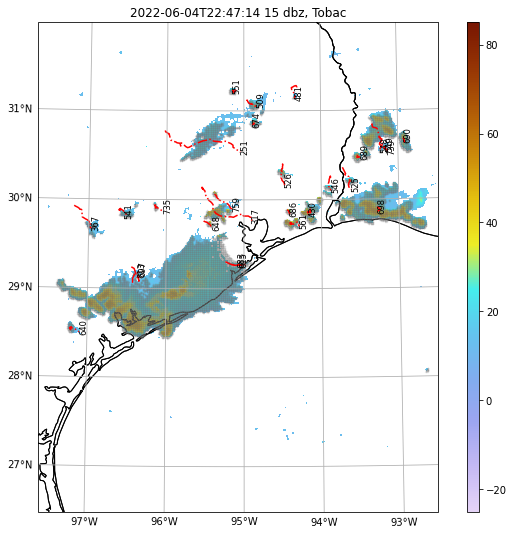

In [42]:
# for i in range(len(nc_grid.time)):
i = 55
time_index = i
#    if i < 13:
#         continue
#     if i > 21:
#         continue

#print(p)
# time_step = str(nc_grid['time'][time_index].values)
#print(time_step)
fig = plt.figure(figsize=(9,9))
fig.set_canvas(plt.gcf().canvas)
plot(time_index,both_ds,maxrefl,nc_grid,15)

#     fig.savefig(savedir+'/20220624_tobac_15dbz_tracks'+str(time_index)+'_KHGX.png')
